# NLP : Spam detection in SMS (text) data using TensorFlow2

## Introduction

Today, internet and social media have become fastest and easiest ways to get information. In this age, reviwes, opinions, feedbacks, messages and recommendations have become significant source of informtion. Thanks to advancement in technologies, we are now able to extract meaningful information out of such data using various Natural Language Processing (NLP) techniques. NLP , a branch of Artificial Intelligence (AI) makes use of computers and human natural language to output valuable information. NLP is commonly used in text classification task such as spam detecetion and sentiment analyisis, text generation, language translations and document classification. 

## Purpose
The main purpose of this article is to understand how we can use TensorFlow2 to build spam detection model. 
Particulary, we focus on building a binary classification model to detect which text messages are spam or not (aka Ham). Moroever, given a text message we’ve never seen before, detect whether or not that message is Spam or Ham.

## Data
This a text data downloaded from [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). It contains 5574 SMS phone messages. The data were collected for the purpose of mobile phone spam research. The data have been labled as either spam or ham. 

## Method
We will use Dense text classifier , Long Short Term Memory(LSTM) and Bi-directional LSTM and compare these methods in terms of performance and runtime. 

The work here is broken down in multiple steps:

* Load and explore the spam data
* Prepare train test data
* Train the spam detection model using the three approaches metioned earlier
* Select one as a final model
* Use the final trained classifier to classify the text


First, let's make sure our tensorflow version is 2. 

In [1]:
import tensorflow as tf
print(tf.__version__)

2.10.0


Next, let's import packages that we need. It's good practice to keep all the imports at the beginning of the code. In any project, as you work through the analysis and find you need to import a package, make sure to add the import up here at the benginning.

In [3]:
# import libarries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# library for train test split
from sklearn.model_selection import train_test_split

# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D,  Flatten, Dense, Dropout, LSTM, SpatialDropout1D, Bidirectional


## Load and explore the spam data

The data is dowloaded from [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) and saved in a local folder. The text file is also provided in github location hence can be read using below syntax. The text file is a tab separated (\t) file. Hence, we can use pandas to read in data as a dataframe. We can also provide the columns name by passing names, call it label and message.

In [4]:
url = 'https://raw.githubusercontent.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/master/SMSSpamCollection'
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


Let's do some data visualization and summary statistics to understand data better. The describe method from pandas provide a summary distribution. Such as, there are 5572 lables and messages. There are two unique lables indicating for "ham" and "spam". We can also observe that there are less unique messages (5169) than total message count(5572) indicating some repeated messages. The top label is ham and the top message in the data is "Sorry, I'll call later". The duplicatedRow below shows, there are 403 duplicated messages. 



In [5]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


Next  let's group by spam and ham to better understand at segment level. There are 4825 ham compared to 747 spam messages. This indicates the class is imbalanced and we may need to fix this. The most popular ham message is "Sorry, I'll call later" whereas the most popular spam message is "Please call our customer service..." which occured 4 times in the data. 

In [7]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

Below, we further explore about the data by label groups. Let's create a WordCloud and distribution bar chart to visualize the data. 

In [8]:
# get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

# For ham and spam messages, create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

First 300 characters of ham message numpy list shown below. 

In [9]:
ham_msg_text[:300]

"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... Ok lar... Joking wif u oni... U dun say so early hor... U c already then say... Nah I don't think he goes to usf, he lives around here though Even my brother is not like to speak with me. "

To visualize using WordCloud, we now extract words most commonly found in ham and spam messages, remove meaningless word such as the, a...stop words and plot it. The WordCloud visualizes the most frequent words in the given text.

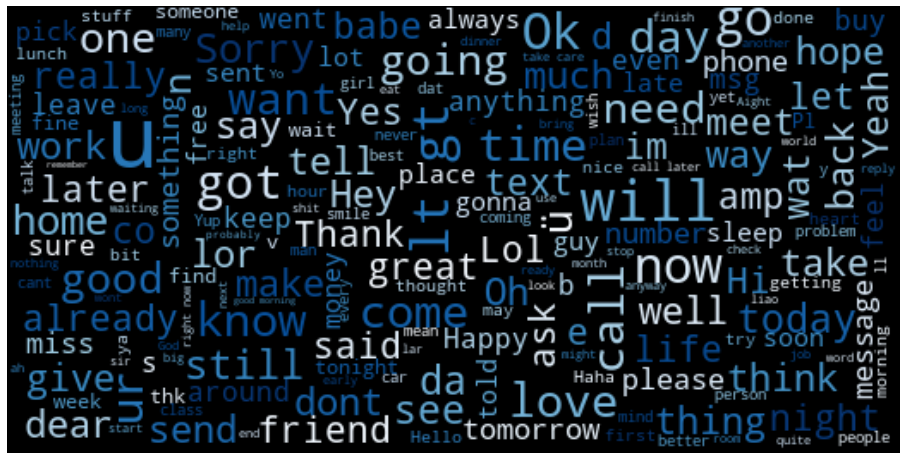

In [10]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, 
                          background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

The ham message WordCloud above shows that words like now, work, How, Ok, Sorry etc are most commonly appeared word in ham message. 

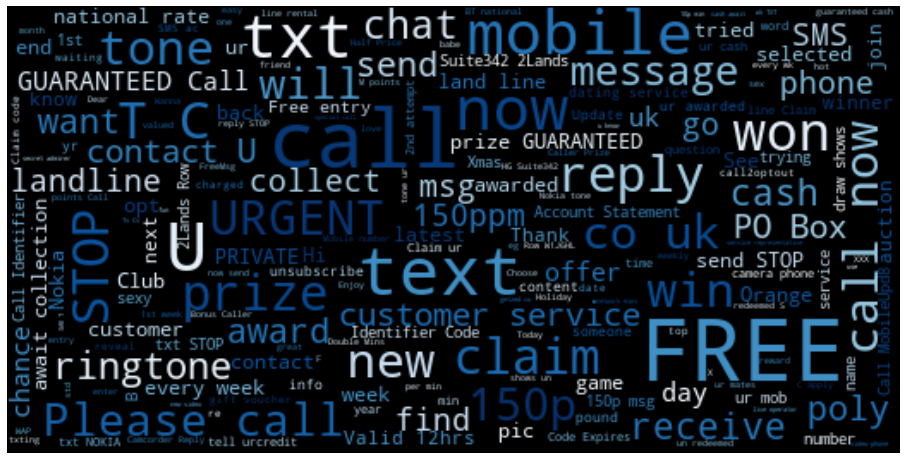

In [11]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, 
                          background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

The spam message WordCloud above shows that words Free, call, text, claim, reply etc are most commonly appeared word in spam message. 

Below, the bar chart shows that the classes are imbalanced. There are most frequent ham messages (85%) than spam (15%). 

C:\Users\Vishal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of ham and spam email messages')

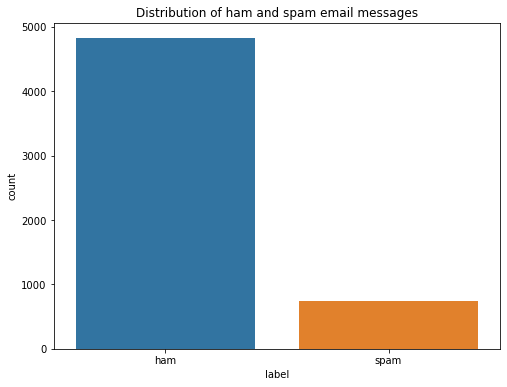

In [12]:
# we can observe imbalance data here. 
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
plt.title('Distribution of ham and spam email messages')

In [13]:
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100

15.481865284974095

There are several ways to handle the imbalance data, for instance
* use of appropriate evaluation metrics
* resampling the training set : oversampling/upsampling or undersampling/downsampling
* ensemble different resample datasets 

However, for our problem, we use undersampling just to show how it is done. You can ofcourse, try other techniques and compare the results. 

Undersampling is the process where you randomly delete some of the observations from the majority class so that the numbers in majority and minority classes are matched. As we can see below, now there are 747 messages of each label type. 

In [14]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg

In [15]:
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


In [16]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)

C:\Users\Vishal\AppData\Local\Temp\ipykernel_11152\3960852085.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)


C:\Users\Vishal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Message types')

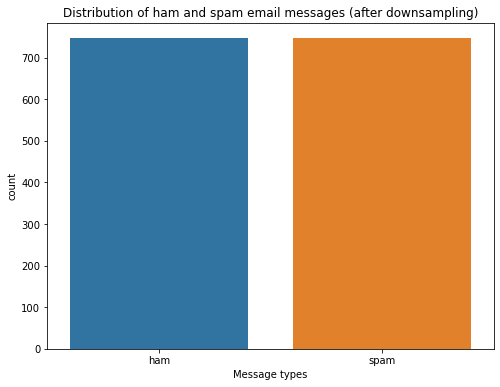

In [18]:
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

Next, a final dataframe is created and calculated the text length column. We further explored length of each of the text by lable types. On average, the ham message has length of 73 words whereas spam message has 138. 

In [19]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)

#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
ham,73.238286
spam,138.670683


## Prepare train test data and pre-processing text
First, we need to convert the text label to numeric and split the data into training set and testing set. Also, convert label to numpy arrays to fit deep learning models. 80% of data were used for training and 20% for testing purposes. 

In [20]:
#msg_df['msg_type']= msg_df['label'].apply(lambda x: 1 if x =='spam' else 0)
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values

In [21]:
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

Below, define the pre-processing hyperparameters and prepare data for training. Particularly we'll use text pre-processing which include:
- Tokenization
- Sequencing
- Padding

For more information on pre-processing text data, please refer to my previous [article](https://medium.com/@statistics.sudip/nlp-preparing-text-for-deep-learning-model-using-tensorflow2-461428138657) on pre-processing data for deep learning model. 

#### Tokenization
As deep learning models do not understand text, we need to convert text into numerical representation. For this purpose, a first step is Tokenization. The Tokenizer API from TensorFlow Keras splits sentences into words and encodes these into integers. Tokenizer will do all required pre-processing such as 
- tokenize into word or charachter - here its at word level
- num_words for maximum number of unique tokens hence we can filter out rare words
- filter out punctuation terms
- convert all words to lower case
- convert all words to integer index

Below, let's define hyper-parameters used for Tokenization. These hyper-parmaters are briefly discussed as we use these in the code. 

In [22]:
# Defining pre-processing hyperparameters
max_len = 50 # pad_sequencs parameter, it idicates we are only going to look for 50 words in a sentence
trunc_type = "post" # pad_sequences parameter
padding_type = "post" # pad_sequences parameter
oov_tok = "<OOV>" # out of vocabulary token
vocab_size = 500

In [23]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

Hyper-parameters used in Tokenizer object are: num_words and oov_token. 
* num_words: indicate how many unique word you want to load in training and testing data. For our purpose, we selected 500 words (vocab_size)
* oov_token: When its used, out of vocabulary token will be added to word index in the corpus which is used to build the model. This is used to replace out of vocabulary words (words that are not in our corpus) during text_to_sequence calls (see below).

In [24]:
# Get the word_index
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 '2': 12,
 'and': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'ur': 19,
 'have': 20,
 '4': 21,
 'txt': 22,
 'of': 23,
 'are': 24,
 'with': 25,
 'me': 26,
 'from': 27,
 'text': 28,
 'get': 29,
 'my': 30,
 'it': 31,
 'stop': 32,
 'just': 33,
 'mobile': 34,
 'this': 35,
 'will': 36,
 'be': 37,
 'no': 38,
 'that': 39,
 'claim': 40,
 'reply': 41,
 'can': 42,
 'so': 43,
 'send': 44,
 'www': 45,
 'we': 46,
 'only': 47,
 'our': 48,
 'not': 49,
 'out': 50,
 'at': 51,
 'do': 52,
 'if': 53,
 'prize': 54,
 'new': 55,
 'go': 56,
 'cash': 57,
 'but': 58,
 '150p': 59,
 'uk': 60,
 '1': 61,
 'nokia': 62,
 'who': 63,
 't': 64,
 'all': 65,
 'win': 66,
 'please': 67,
 'won': 68,
 'up': 69,
 'tone': 70,
 'when': 71,
 "i'm": 72,
 'week': 73,
 'been': 74,
 'what': 75,
 'msg': 76,
 '50': 77,
 'com': 78,
 'urgent': 79,
 'how': 80,
 'service': 81,
 'phone': 82,
 'time': 83,
 

In [25]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4169 unique tokens in training data. 


#### Sequencing and Padding

Once tokenization is done, let's represent each sentence by sequences of numbers using texts_to_sequences from tokenizer object. Subsequently, we padded the sequence so that we can have same length of each sequence.  Sequencing and padding are done for both training and testing data.

In [26]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, 
                                 padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                              padding = padding_type, truncating = trunc_type)

- padding = 'pre' or 'post (default pre). By using pre, we'll pad before each sequence and post will pad after each sequence.
- maxlen = maximum length of all sequences. If not provided, by default it will use the maximum length of the longest sentence.
- truncating = 'pre' or 'post' (default 'pre'). If a sequence length is larger than the provided maxlen value then, these values will be truncated to maxlen. 'pre' option will truncate at the beginning where as 'post' will truncate at the end of the sequences.

In [27]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [28]:
# Before padding : first sequence is 27 character long where as second one is 24
len(training_sequences[0]), len(training_sequences[1])

(27, 24)

In [29]:
# Padded to same length of 50
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [30]:
# As can be seen from below, the padded sequence is 50 words long. 
print(training_padded[0])

[  1  47 186   9  34   1   3  24   1   2 274   2   7 152 275 135  34  10
  15   6   7  34 274  85  15  17   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## Train the Model

#### Dense Spam Detection Architechture

Below is a model architecture of dense spam detection model. 

- Sequential calls for Keras sequential model in which layers are added in a sequence
- The first layer i.e. embedding layer maps each word to a N-dimensional vector of real numbers. The embeding_dim is the size of this vector which is 16 in our case. The embeding layer indicates that the two words with similar meaning tend to have very close vectors. Because, the embedding layer is the first hiddne layer in our model network, we need to pass shape of our input layer as defined by input_length (max_len =50).
- The pooling layer helps to reduce the number of parameters in the model hence helps to avoid overfitting. We have used average pooling here and coverted layer to 1 dimension.

- Next we used a dense layer with activation function 'relu' followed by a dropout layer to avoid overfitting and a final outpout layer with sigmoid activation function. As there are only two classes (ham or spam) to classify, we used only a single output neuron. The sigmoid activation function outputs probabilities between 0 and 1. 

- Here, we used fairly a shallow neural network architecture, however, you can  make it more dense adding more layers.

In [31]:
vocab_size = 500 # Number of words you want to tokenize i.e maximum number of words to keep
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [32]:
#Dense sentiment model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

The model.summary() provides the layer, shape and number of parameters used in each layer. In the embedding layer, the 8000 parameter comes from 500 words (vocab_size), each one with a 16 dimensional word-vector space (500 X 16 = 8000). The embedding layer is passed through GlobalAveragePooling1D  and into dense layers have shape of 16 (due to the avereage pooling along 16 embedding dimension). We selected 24 neurons for the dense hidden layer. Each of the 24 neurons in the dense layer gets input from each of the 16 values coming from the GlobalAveragePooling1D layer, for a total of 384 (16 X 24) weights and 24 biases (one for each 24 neurons). Hence the total parameter is 408. Finally, the output layer has 24 weights (one for each neuron) and its bias resulting 25 parameters. 

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

Let's compile our dense spam classifier model. We used 'binary_crossentropy' as a loss function because of binary output. We used 'adam' as an optimiser which makes use of  momentum to avoid local minima and 'accuracy' as a measure of model performance. 

In [34]:
# Compile model
#from tensorflow import keras
# Using Adam optimiser which makes use of momentum to avoid local minima
#optim = keras.optimizers.Adam(learning_rate=0.00001)

In [35]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

Next let's fit our dense classifier using model.fit argument. It uses padded training data and training labels for training the model and validation data for validating. 

* Epoch: Number of times the learning algorithm will work through the entire training data set. We set it to be 20. 
* callbacks: callbacks is used to pass the early stopping parameter. EarlyStopping(monitor='val_loss', patience=2) was used to define that we want to monitor the validation loss and if the validation loss is not improved after two epochs, then the model training is stopped. It helps to avoid overfitting problem and indicates when to stop training before the learner begins over-fit. 
* verbose =2: lets to print loss and accuracy on each epoch

In [36]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 1s - loss: 0.6872 - accuracy: 0.5615 - val_loss: 0.6796 - val_accuracy: 0.7023 - 1s/epoch - 35ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6684 - accuracy: 0.7958 - val_loss: 0.6527 - val_accuracy: 0.7926 - 74ms/epoch - 2ms/step
Epoch 3/30
38/38 - 0s - loss: 0.6260 - accuracy: 0.8335 - val_loss: 0.5962 - val_accuracy: 0.8227 - 91ms/epoch - 2ms/step
Epoch 4/30
38/38 - 0s - loss: 0.5586 - accuracy: 0.8577 - val_loss: 0.5258 - val_accuracy: 0.8495 - 86ms/epoch - 2ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4816 - accuracy: 0.8787 - val_loss: 0.4548 - val_accuracy: 0.8696 - 78ms/epoch - 2ms/step
Epoch 6/30
38/38 - 0s - loss: 0.4059 - accuracy: 0.8979 - val_loss: 0.3907 - val_accuracy: 0.8729 - 79ms/epoch - 2ms/step
Epoch 7/30
38/38 - 0s - loss: 0.3426 - accuracy: 0.8979 - val_loss: 0.3376 - val_accuracy: 0.8796 - 80ms/epoch - 2ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2894 - accuracy: 0.9079 - val_loss: 0.2954 - val_accuracy: 0.8896 - 79ms/epoch - 2ms/step
Epoch 9/30
38/38 - 0s - l

In [37]:
# Model performermance on test data is about 9465% accuracy with validation loss of 0.11.
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 1ms/step - loss: 0.1269 - accuracy: 0.9431


[0.12692174315452576, 0.9431437849998474]

In [38]:
metrics = pd.DataFrame(history.history)
metrics[:2]

,loss,accuracy,val_loss,val_accuracy
0,0.687183,0.561506,0.679626,0.702341
1,0.668435,0.795816,0.652693,0.792642


In [39]:
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
metrics[:2]

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.687183,0.561506,0.679626,0.702341
1,0.668435,0.795816,0.652693,0.792642


In [40]:
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Dense Classifier: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

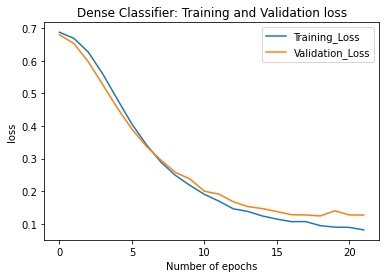

In [41]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

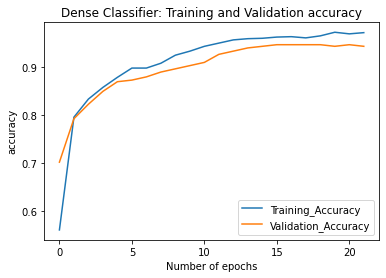

In [42]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

### Compare three different models
Based on loss, accuracy and the plots above, we can select Dense architecture as a final model for classifying the text messages. The Dense architecture model has validation accruacy of about 95% and loss of 0.12.

In [73]:
# model accuracy
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )

10/10 [==============================] - 0s 1ms/step - loss: 0.1269 - accuracy: 0.9431
Dense architecture loss and accuracy: [0.12692174315452576, 0.9431437849998474] 


# Predict sentiment for new messages

Scenario 1: Using raw text from our data:

Let's see how our Dense spam detection model predicts/classifies whether its spam or ham given the text from our original data. First and second mssages below are ham whereas the third one is a spam message. We've used the same tokenizer that we created earlier in the code to convert them into the sequences. This makes sure the new words will have the same token as in the training set. Once tokenized, we use padding as we did earliner and provide the same dimension as in training set. 

As shown below, the model correctly predicts first two sentences as ham where as the third one as spam. 


In [64]:
# display long string 
pd.options.display.max_colwidth=100
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...


In [65]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))

In [60]:
predict_spam(predict_msg)

1/1 [==============================] - 2s 2s/step


array([[0.02681904],
       [0.01188749],
       [0.99908453]], dtype=float32)

Scenario 2: Using newly created text and see how the model classifies them. 
    
Below, first sentence is more like a spam whereas the rest of the two sentences are more like ham. 

In [71]:
# The third one gives 0.99 indicating very high probabilty of spam
predict_msg = ["You are awarded a Nikon Digital Camera. Call now",
               "Call me",
          "What's up?"]
predict_spam(predict_msg)

1/1 [==============================] - 0s 22ms/step


array([[0.8800329 ],
       [0.05949988],
       [0.02964362]], dtype=float32)

As shown above, the model seems to be correctly classifying ham and spam messages. 

## Summary

We used the text messages from  [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) and fit deep learning models such as Dense architecture, LSTM and Bi-LSTM and compared the accuracy and loss on validation set across these models. Finally, we selected the Dense architectural deep learning model to classify text messages as spam or ham. This article, provides an oveview of using different architectural deep learning models to NLP problem using TensorFlow2. 

## Next Step

Next, we could explore more sampling approaches such as upsampling, using SMOTE, using overall sample and fitting the model. We could also try using more dense network and see how it fits the data. 

## Acknowledgement!

I would like to thank Jon Krohn for his book Deep Learning Illustrated, Lazy programmer Inc for their excellent course "Tensorflow 2.0: Deep Learning and Artificial Intelligence" and Jose Portilla for awesome course "Complete Tensorflow 2 and Keras Deep Learning Bootcamp" on Udemy. 